# Gesture Recognition - Vinay Kuchhal & Satish Singh


### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).


### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [5]:
# Importing all necessary libraries

import numpy as np
import os
import datetime

from imageio import imread
import cv2
from cv2 import resize
import datetime
import os
import pandas as pd
from tensorflow import keras 
import matplotlib.pyplot as plt





We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [7]:
tf.__version__

'2.4.1'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [8]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())



### Viewing a sample Image

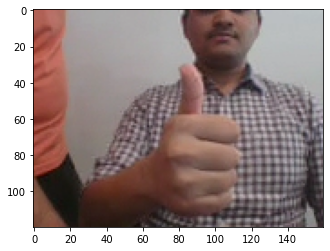

In [9]:
sample_im_path = './Project_data/train'+'/'+ train_doc[5].split(';')[0]
sample = imread(sample_im_path+'/'+os.listdir(sample_im_path)[0])

plt.imshow(sample)

In [10]:
# Shape of the image

sample.shape

(120, 160, 3)

In [11]:
# resizeing to 120, 120
sample = resize(sample,(120,120))

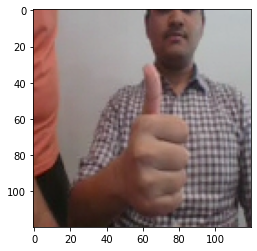

In [12]:
plt.imshow(sample)

### Checking for Class Impbalance

In [13]:
train_df = pd.read_csv('Project_data/train.csv', sep= ';', header=None)

In [14]:
train_df.rename(columns = {0: 'Name', 1: 'Gesture', 2: 'Class'},inplace = True)
train_df.head()

,Name,Gesture,Class
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


In [15]:
train_df['Class'].value_counts()/len(train_df)*100

1    20.663650
3    20.663650
0    20.512821
2    19.607843
4    18.552036
Name: Class, dtype: float64

### Inferance - We can see that the data is fairly balanced, with all the 5 classes being close to 20%

## Defining frequently used functions

In [16]:
def plot_acc(history):
    
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [17]:
all_frames=30 # Total No. of frames images= x
act_frames = 20 # Number of frames to sample
image_width = 160 # Width of the image = y
image_height = 160 # height of the image = z
batch_size = 100 #experiment with the batch size
num_epochs = 50 # choose the number of epochs

In [18]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size, '; Image width =', image_width, '; Image height =', image_height)
    
    # Looking at the 30 frames of any one single video, we realized that there is hardly any 
    # movement/gesture in the beging and at the end. Hence, we are discarding the first 5 and the last 5 
    # frames for traning
    
    img_idx = np.round(np.linspace(5, 25, act_frames)).astype(int)  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_width, image_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image_resized = cv2.resize(image, (image_height,image_width), interpolation = cv2.INTER_AREA)
                    
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size, len(img_idx), image_width, image_height, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = cv2.resize(image, (image_height,image_width), interpolation = cv2.INTER_AREA)
                   
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255  #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [19]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers



#write your model here

In [17]:
def conv3d_1_compile(act_frames, image_height, image_width, optimizer):
    print('Image= ', image_width, 'X', image_height)

    model_1 = Sequential()       
    model_1.add(Conv3D(16,kernel_size=(3,3,3),input_shape=(act_frames, image_height, image_width, 3),padding='same'))
    model_1.add(Activation('relu'))
    model_1.add(BatchNormalization())
    model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_1.add(Conv3D(32, (3, 3, 3), padding='same'))
    model_1.add(Activation('relu'))
    model_1.add(BatchNormalization())
    model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_1.add(Conv3D(64, (3, 3, 3), padding='same'))
    model_1.add(Activation('relu'))
    model_1.add(BatchNormalization())
    model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_1.add(Conv3D(128, (3, 3, 3), padding='same'))
    model_1.add(Activation('relu'))
    model_1.add(BatchNormalization())
    model_1.add(MaxPooling3D(pool_size=(2, 2, 2)))
     

    # Flatten layer 

    model_1.add(Flatten())

    model_1.add(Dense(64, activation='relu'))
    model_1.add(BatchNormalization())
    model_1.add(Dropout(0.2))

    model_1.add(Dense(64, activation='relu'))
    model_1.add(BatchNormalization())
    model_1.add(Dropout(0.2))

    #Softmax layer

    model_1.add(Dense(5, activation='softmax'))
        
    #Now that you have written the model, the next step is to compile the model. 
    #When you print the summary of the model, you'll see the total number of parameters you have to train.

    
    optimiser = 'adam'
    model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model_1.summary())
    
    return model_1
  

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### Defining frequently used functions

#### 1. Define a model training function

In [18]:
def train_model(train_path, train_doc, batch_size, model):
    # Let us create the train_generator and the val_generator which will be used in .fit
    
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    curr_dt_time = datetime.datetime.now()
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
   # earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
   # callbacks_list = [checkpoint, LR, earlystop]
    callbacks_list = [checkpoint, LR]
    
    #The steps_per_epoch and validation_steps are used by .fit to decide the number of next() calls it need to make.
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    #Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.    
    #model_num=model_n
    history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history


#### 2. Define a ploting function

In [19]:
def plot_acc(history):
    
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()

### Model 1: Conv3D
#### Parameters

- image_width = 160
- image_height = 160 
- batch_size = 100 
- num_epochs = 50 

In [14]:
# Model 1
# Initialze the parameters

image_width = 160
image_height = 160
batch_size = 100
num_epochs = 50

#params_initialize(160, 160, 100, 50)


model = conv3d_1_compile(act_frames, image_height, image_width, 'adam')

Image=  160 X 160
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10

In [16]:
# Train the model

history = train_model(train_path, train_doc, batch_size, model)



Source path =  Project_data/train ; batch size = 100 ; Image width = 160 ; Image height = 160
Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[100,16,10,80,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad (defined at <ipython-input-12-3bd4c9d73fb6>:37) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_2713]

Function call stack:
train_function


### Inference - Model 1
- We started with a high Batch Size of 100 and found that it ended in out of memory error
- Hence, we will reduce the bacth size to 50 for the next model and try

# Model 1.1: Conv3D
#### Parameters

- image_width = 160
- image_height = 160 
- __batch_size = 50__ 
- num_epochs = 50 

In [15]:
# Model 1.1
# Initialze the parameters

image_width = 160
image_height = 160
batch_size = 50
num_epochs = 50


model = conv3d_1_compile(act_frames, image_height, image_width, 'adam')

Image=  160 X 160
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 

In [16]:
# Train the model

history = train_model(train_path, train_doc, batch_size, model)


Source path =  Project_data/train ; batch size = 50 ; Image width = 160 ; Image height = 160
Epoch 1/50
14/14 [==============================] - 115s 8s/step - loss: 1.7473 - categorical_accuracy: 0.3759 - val_loss: 1.5366 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 1.53656, saving model to model_init_2022-07-1208_14_53.415441/model-00001-1.51514-0.44495-1.53656-0.24000.h5
Epoch 2/50
14/14 [==============================] - 23s 2s/step - loss: 1.1491 - categorical_accuracy: 0.5418 - val_loss: 1.9595 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.53656
Epoch 3/50
14/14 [==============================] - 23s 2s/step - loss: 1.2269 - categorical_accuracy: 0.5388 - val_loss: 1.9961 - val_categorical_accuracy: 0.1800

Epoch 00003: val_loss did not improve from 1.53656
Epoch 4/50
14/14 [==============================] - 22s 2s/step - loss: 1.2016 - categorical_accuracy: 0.4982 - val_loss: 1.9478 - val_categorical_accuracy: 

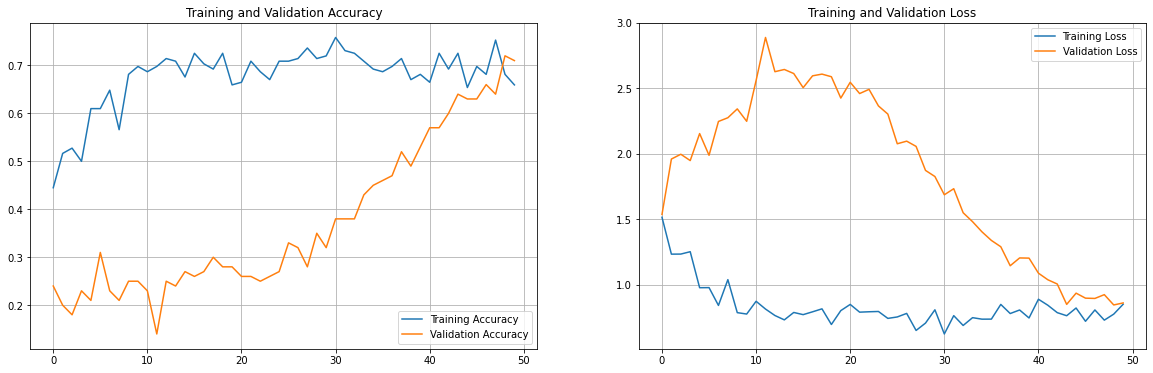

In [17]:
# Plot the results
plot_acc(history)

### Inference - Model 1.1
- We see that the model isn't doing very well.
- Both Train and Val accuracy reach around 70-75%, but only after 45 epochs

### Model 1.2: Conv3D - Reducing the image resolution to 120x120
#### Parameters

- image_width = 120
- image_height = 120 
- batch_size = 50 
- num_epochs = 50 

In [18]:
# Model 1.2
# Initialze the parameters

image_width = 120
image_height = 120
batch_size = 50
num_epochs = 50



model = conv3d_1_compile(act_frames, image_height, image_width, 'adam')

Image=  120 X 120
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 

In [19]:


# Train the model
history = train_model(train_path, train_doc, batch_size, model)



Source path =  Project_data/train ; batch size = 50 ; Image width = 120 ; Image height = 120
Epoch 1/50
14/14 [==============================] - 46s 3s/step - loss: 1.7245 - categorical_accuracy: 0.3557 - val_loss: 1.6320 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.63204, saving model to model_init_2022-07-1208_50_11.194032/model-00001-1.50040-0.42986-1.63204-0.20000.h5
Epoch 2/50
14/14 [==============================] - 19s 1s/step - loss: 1.0732 - categorical_accuracy: 0.5943 - val_loss: 1.8534 - val_categorical_accuracy: 0.3600

Epoch 00002: val_loss did not improve from 1.63204
Epoch 3/50
14/14 [==============================] - 19s 1s/step - loss: 1.1074 - categorical_accuracy: 0.5726 - val_loss: 1.9722 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.63204
Epoch 4/50
14/14 [==============================] - 19s 1s/step - loss: 1.0386 - categorical_accuracy: 0.5985 - val_loss: 2.0724 - val_categorical_accuracy: 0

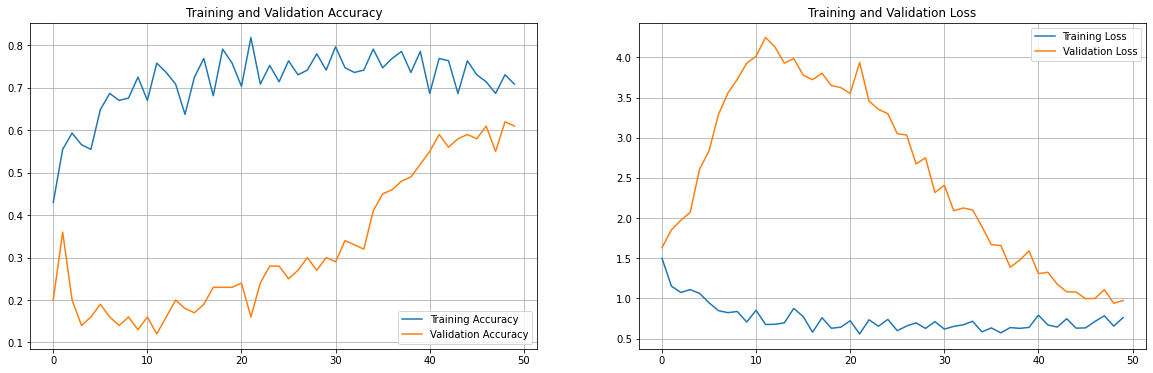

In [20]:
# Plot the results
plot_acc(history)

### Inference - Model 1.2
- We see that the validation accuracy is lower than model 1.1.
- But we also see notice the uptrend in the validation accuracy, hence we will train again with epochs =100

### Model 1.3: Conv3D - Increasing the epochs to 100
#### Parameters

- image_width = 120
- image_height = 120 
- batch_size = 50 
- num_epochs = 100

In [21]:
# Model 1.3
# Initialze the parameters

image_width = 120
image_height = 120
batch_size = 50
num_epochs = 100



model = conv3d_1_compile(act_frames, image_height, image_width, 'adam')

Image=  120 X 120
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 

In [22]:
# Train the model
history = train_model(train_path, train_doc, batch_size, model)


Source path =  Project_data/train ; batch size = 50 ; Image width = 120 ; Image height = 120
Epoch 1/100
14/14 [==============================] - 46s 3s/step - loss: 1.8711 - categorical_accuracy: 0.3426 - val_loss: 1.5220 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 1.52202, saving model to model_init_2022-07-1209_06_37.441359/model-00001-1.67296-0.38763-1.52202-0.36000.h5
Epoch 2/100
14/14 [==============================] - 19s 1s/step - loss: 1.1284 - categorical_accuracy: 0.5429 - val_loss: 1.8234 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.52202
Epoch 3/100
14/14 [==============================] - 19s 1s/step - loss: 1.4980 - categorical_accuracy: 0.4513 - val_loss: 2.0589 - val_categorical_accuracy: 0.2600

Epoch 00003: val_loss did not improve from 1.52202
Epoch 4/100
14/14 [==============================] - 19s 1s/step - loss: 1.4309 - categorical_accuracy: 0.4980 - val_loss: 2.6601 - val_categorical_accurac

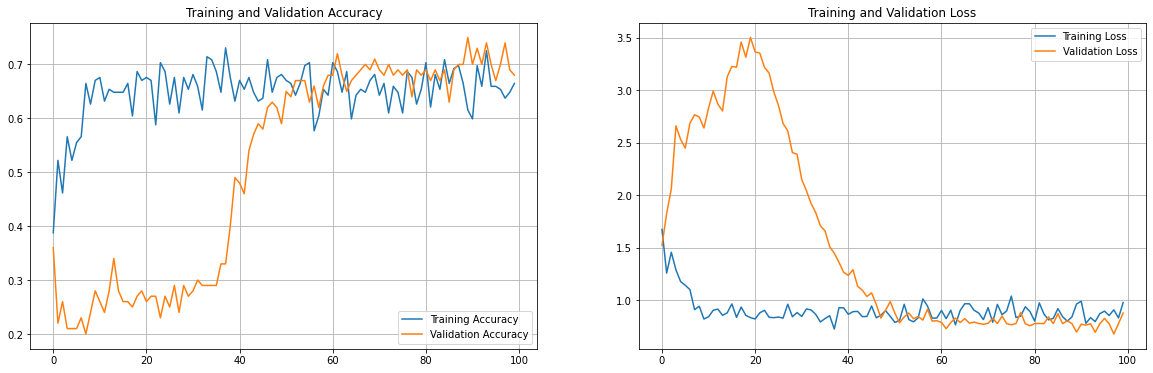

In [23]:
# Plot the results
plot_acc(history)

### Inference - Model 1.3
- We see that the model perfomring decently well beyond 50 epochs with the accuracy for both the training and validation around 70%
- However, 100 epochs seems to be an overkill, as the model did not improve after 50 epochs

### Model 1.4: Conv3D -  resolution to 140x140 and epochs=60
#### Parameters

- image_width = 140
- image_height = 140 
- batch_size = 50 
- num_epochs = 60

In [24]:
# Model 1.4
# Initialze the parameters

image_width = 140
image_height = 140
batch_size = 50
num_epochs = 60


model = conv3d_1_compile(act_frames, image_height, image_width, 'adam')

Image=  140 X 140
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 140, 140, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 20, 140, 140, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 140, 140, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 70, 70, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 70, 70, 32)    13856     
_________________________________________________________________
activation_17 (Activation)   (None, 10, 70, 70, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 

In [25]:
# Train the model
history = train_model(train_path, train_doc, batch_size, model)

Source path =  Project_data/train ; batch size = 50 ; Image width = 140 ; Image height = 140
Epoch 1/60
14/14 [==============================] - 51s 4s/step - loss: 1.6845 - categorical_accuracy: 0.3763 - val_loss: 1.5201 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.52014, saving model to model_init_2022-07-1209_38_52.597816/model-00001-1.50037-0.43741-1.52014-0.25000.h5
Epoch 2/60
14/14 [==============================] - 22s 2s/step - loss: 1.1694 - categorical_accuracy: 0.5913 - val_loss: 1.7579 - val_categorical_accuracy: 0.3300

Epoch 00002: val_loss did not improve from 1.52014
Epoch 3/60
14/14 [==============================] - 21s 2s/step - loss: 1.1219 - categorical_accuracy: 0.5711 - val_loss: 1.8382 - val_categorical_accuracy: 0.3000

Epoch 00003: val_loss did not improve from 1.52014
Epoch 4/60
14/14 [==============================] - 22s 2s/step - loss: 1.1010 - categorical_accuracy: 0.5971 - val_loss: 1.9679 - val_categorical_accuracy: 0

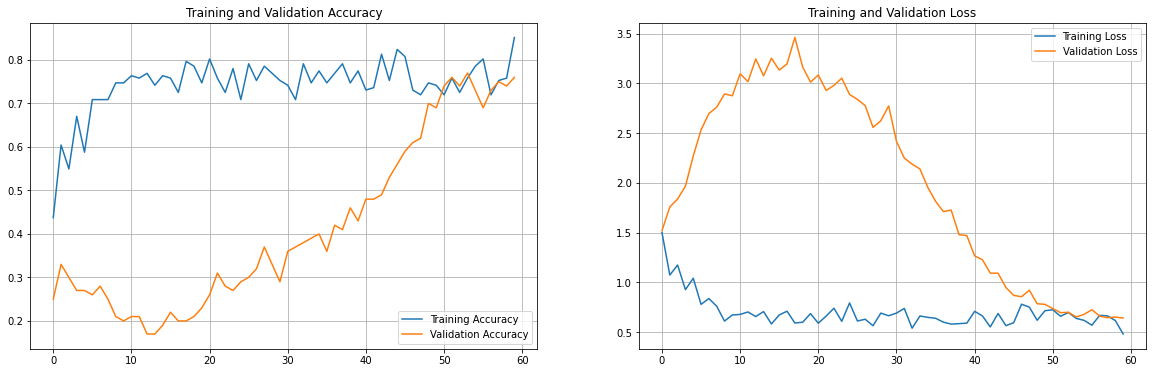

In [26]:
# Plot the results
plot_acc(history)

### Inference - Model 1.4
- This model's performance is almost as good as the model 1.3.
- Since for model 1.3 resolution was 120x120, we will choose model 1.3 over model 1.4 (lower total parameters)

### Model 1.5: Conv3D -  resolution to 160x160 and epochs=60
#### Parameters

- image_width = 160
- image_height = 160 
- batch_size = 50 
- num_epochs = 60

In [33]:
# Model 1.5
# Initialze the parameters

image_width = 160
image_height = 160
batch_size = 50
num_epochs = 60


model = conv3d_1_compile(act_frames, image_height, image_width, 'adam')

Image=  160 X 160
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_29 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 

In [34]:
# Train the model
history = train_model(train_path, train_doc, batch_size, model)

Source path =  Project_data/train ; batch size = 50 ; Image width = 160 ; Image height = 160
Epoch 1/60
14/14 [==============================] - 118s 9s/step - loss: 1.8492 - categorical_accuracy: 0.3511 - val_loss: 2.1365 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 2.13652, saving model to model_init_2022-07-1210_31_10.703050/model-00001-1.57128-0.42081-2.13652-0.25000.h5
Epoch 2/60
14/14 [==============================] - 40s 3s/step - loss: 1.1084 - categorical_accuracy: 0.5822 - val_loss: 1.6233 - val_categorical_accuracy: 0.3200

Epoch 00002: val_loss improved from 2.13652 to 1.62325, saving model to model_init_2022-07-1210_31_10.703050/model-00002-1.02327-0.62088-1.62325-0.32000.h5
Epoch 3/60
14/14 [==============================] - 43s 3s/step - loss: 1.1220 - categorical_accuracy: 0.5832 - val_loss: 1.9566 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.62325
Epoch 4/60
14/14 [==============================] - 

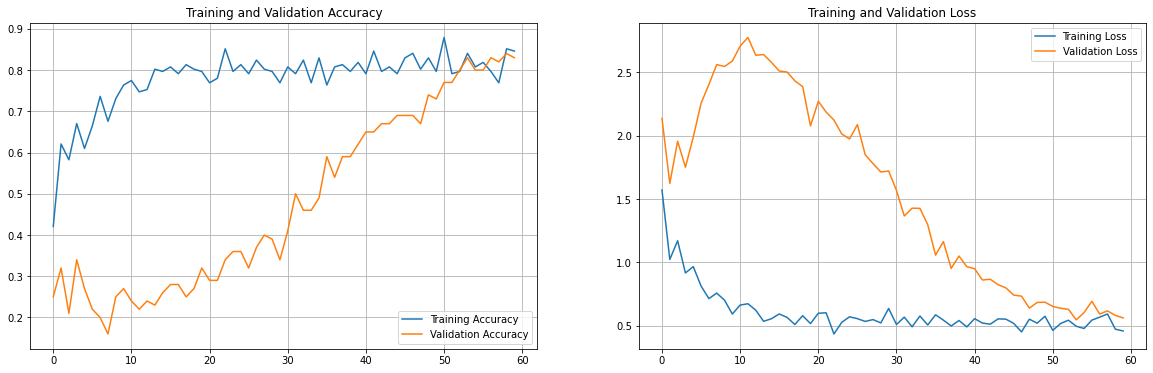

In [36]:
# Plot the results
plot_acc(history)

### Inference - Model 1.5
- This model's is same as model 1.1, but with epochs = 60 rather than 50. 
- We are getting an accuracy of close to 83% for both train and validation data.
- __This model is our best model till now__


### Model 2: Conv3D -  resolution to 120x120 and filter size to (2,2,2)
#### Parameters

- image_width = 120
- image_height = 120 
- batch_size = 50 
- num_epochs = 60

In [15]:
def conv3d_2_compile(act_frames, image_height, image_width, optimizer):
    print('Image= ', image_width, 'X', image_height)

    model_2 = Sequential()       
    model_2.add(Conv3D(16,kernel_size=(2,2,2),input_shape=(act_frames, image_height, image_width, 3),padding='same'))
    model_2.add(Activation('relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_2.add(Conv3D(32, (2,2,2), padding='same'))
    model_2.add(Activation('relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_2.add(Conv3D(64, (2,2,2), padding='same'))
    model_2.add(Activation('relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_2.add(Conv3D(128, (2,2,2), padding='same'))
    model_2.add(Activation('relu'))
    model_2.add(BatchNormalization())
    model_2.add(MaxPooling3D(pool_size=(2, 2, 2)))
     

    # Flatten layer 

    model_2.add(Flatten())

    model_2.add(Dense(64, activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))

    model_2.add(Dense(64, activation='relu'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))

    #Softmax layer

    model_2.add(Dense(5, activation='softmax'))
        
    #Now that you have written the model, the next step is to compile the model. 
    #When you print the summary of the model, you'll see the total number of parameters you have to train.

    
    optimiser = optimizer
    model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model_2.summary())
    
    return model_2
  

In [39]:
# Model 2
# Initialze the parameters

image_width = 120
image_height = 120
batch_size = 50
num_epochs = 60


model = conv3d_2_compile(act_frames, image_height, image_width, 'adam')

Image=  120 X 120
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_36 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_37 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 

In [40]:
# Train the model
history = train_model(train_path, train_doc, batch_size, model)

Source path =  Project_data/train ; batch size = 50 ; Image width = 120 ; Image height = 120
Epoch 1/60
14/14 [==============================] - 108s 8s/step - loss: 1.7990 - categorical_accuracy: 0.3680 - val_loss: 1.6463 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from inf to 1.64630, saving model to model_init_2022-07-1211_23_15.497442/model-00001-1.54274-0.43288-1.64630-0.18000.h5
Epoch 2/60
14/14 [==============================] - 39s 3s/step - loss: 1.1072 - categorical_accuracy: 0.5856 - val_loss: 1.8057 - val_categorical_accuracy: 0.2400

Epoch 00002: val_loss did not improve from 1.64630
Epoch 3/60
14/14 [==============================] - 37s 3s/step - loss: 0.9618 - categorical_accuracy: 0.6407 - val_loss: 2.0980 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.64630
Epoch 4/60
14/14 [==============================] - 41s 3s/step - loss: 1.1570 - categorical_accuracy: 0.5811 - val_loss: 2.5148 - val_categorical_accuracy: 

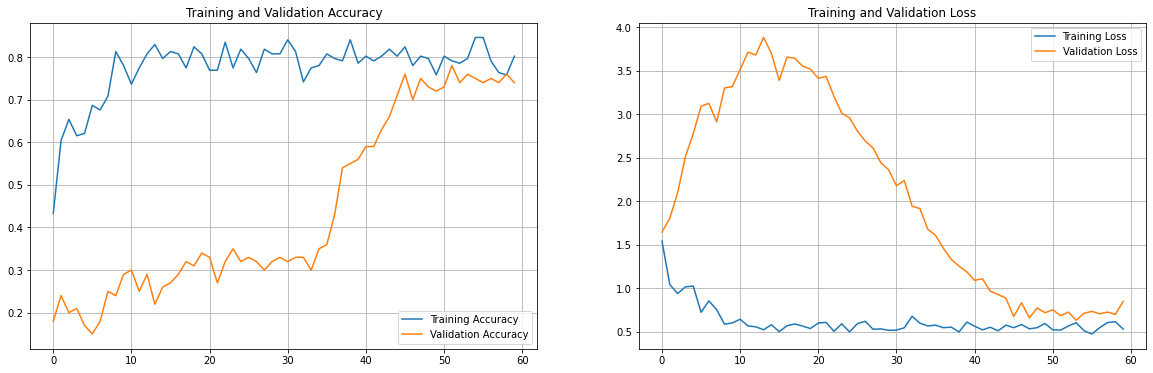

In [41]:
# Plot the results
plot_acc(history)

### Inference - 2
- Train accuracy of around 80% and validation accuracy of around 75%
- We see that the filter size (2,2,2) is doing slightly better than the filter size(3,3,3) for similar parameters
- We will be using (2,2,2) going forward (Lower number of total parameters)


### Model 2.1: Conv3D -  resolution to 160x160 and epochs=60, filter=(2,2,2)
#### Parameters

- image_width = 160
- image_height = 160 
- batch_size = 50 
- num_epochs = 60

In [16]:
# Model 2.1
# Initialze the parameters

image_width = 160
image_height = 160
batch_size = 50
num_epochs = 60


model = conv3d_2_compile(act_frames, image_height, image_width, 'adam')

Image=  160 X 160
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 160, 160, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10

In [17]:
# Train the model
history = train_model(train_path, train_doc, batch_size, model)

Source path =  Project_data/train ; batch size = 50 ; Image width = 160 ; Image height = 160
Epoch 1/60
14/14 [==============================] - 149s 10s/step - loss: 1.7676 - categorical_accuracy: 0.3685 - val_loss: 1.7764 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from inf to 1.77641, saving model to model_init_2022-07-1212_20_25.541892/model-00001-1.39993-0.47813-1.77641-0.18000.h5
Epoch 2/60
14/14 [==============================] - 24s 2s/step - loss: 0.7652 - categorical_accuracy: 0.7225 - val_loss: 2.6764 - val_categorical_accuracy: 0.1300

Epoch 00002: val_loss did not improve from 1.77641
Epoch 3/60
14/14 [==============================] - 25s 2s/step - loss: 0.8235 - categorical_accuracy: 0.6643 - val_loss: 4.5325 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 1.77641
Epoch 4/60
14/14 [==============================] - 24s 2s/step - loss: 1.1291 - categorical_accuracy: 0.5502 - val_loss: 5.3844 - val_categorical_accuracy:

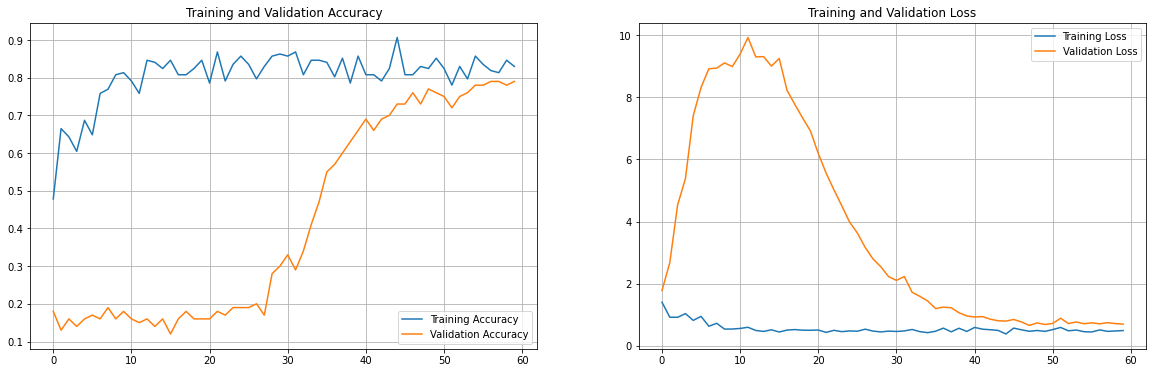

In [18]:
# Plot the results
plot_acc(history)

### Inference - 2.1
- Train accuracy of around 85% and validation accuracy of around 80%
- We see that this model has surely perfomed better than model 2. 
### __Hence we will be using this going forward__

### Model 3: LSTM -  resolution to 160x160 and epochs=60, filter=(2,2,2) 
### *This is optional and not needed since we have already built our model using Conv3D. But we still want to try LSTM and GRU models for our own learning*
#### Parameters

- image_width = 160
- image_height = 160 
- batch_size = 50 
- num_epochs = 60

## LSTM

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

In [21]:
def lstm_1_compile(act_frames, image_height, image_width, optimizer):
    print('Image= ', image_width, 'X', image_height)

    model_l = Sequential()

    model_l.add(TimeDistributed(Conv2D(16, (2,2) , padding='same', activation='relu'),
                                  input_shape=(act_frames,image_height,image_width,3)))
    model_l.add(TimeDistributed(BatchNormalization()))
    model_l.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_l.add(TimeDistributed(Conv2D(32, (2,2) , padding='same', activation='relu')))
    model_l.add(TimeDistributed(BatchNormalization()))
    model_l.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_l.add(TimeDistributed(Conv2D(64, (2,2) , padding='same', activation='relu')))
    model_l.add(TimeDistributed(BatchNormalization()))
    model_l.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_l.add(TimeDistributed(Conv2D(128, (2,2) , padding='same', activation='relu')))
    model_l.add(TimeDistributed(BatchNormalization()))
    model_l.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_l.add(TimeDistributed(Conv2D(256, (2,2) , padding='same', activation='relu')))
    model_l.add(TimeDistributed(BatchNormalization()))
    model_l.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_l.add(TimeDistributed(Flatten()))
    #model_l.add(LSTM(64,return_sequences = False))
    model_l.add(LSTM(64))
    model_l.add(Dropout(0.2))
        
    model_l.add(Dense(64,activation='relu'))
    model_l.add(Dropout(0.2))
        
    model_l.add(Dense(5, activation='softmax'))
    
    
    
    #Now that you have written the model, the next step is to compile the model. 
    #When you print the summary of the model, you'll see the total number of parameters you have to train.

    
    optimiser = optimizer
    model_l.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model_l.summary())
    
    return model_l

In [34]:
# We had to downgrade our numpy installation do deal with the error 'Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array'
#pip install numpy==1.19.5

     |████████████████████████████████| 14.9 MB 3.7 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.2
    Uninstalling numpy-1.20.2:
      Successfully uninstalled numpy-1.20.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires gast==0.3.3, but you have gast 0.4.0 which is incompatible.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.37.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [22]:
image_width = 160
image_height = 160
batch_size = 50
num_epochs = 60


model = lstm_1_compile(act_frames, image_height, image_width, 'adam')

Image=  160 X 160
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 160, 160, 16)  208       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 80, 80, 32)    2080      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20

In [23]:
# Train the model
history = train_model(train_path, train_doc, batch_size, model)

Source path =  Project_data/train ; batch size = 50 ; Image width = 160 ; Image height = 160
Epoch 1/60
14/14 [==============================] - 137s 9s/step - loss: 1.5550 - categorical_accuracy: 0.2735 - val_loss: 1.8358 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from inf to 1.83579, saving model to model_init_2022-07-1215_45_21.312629/model-00001-1.47291-0.33786-1.83579-0.18000.h5
Epoch 2/60
14/14 [==============================] - 22s 2s/step - loss: 1.3746 - categorical_accuracy: 0.4074 - val_loss: 1.8147 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss improved from 1.83579 to 1.81465, saving model to model_init_2022-07-1215_45_21.312629/model-00002-1.35351-0.40110-1.81465-0.26000.h5
Epoch 3/60
14/14 [==============================] - 22s 2s/step - loss: 1.2397 - categorical_accuracy: 0.5371 - val_loss: 1.9742 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.81465
Epoch 4/60
14/14 [==============================] - 

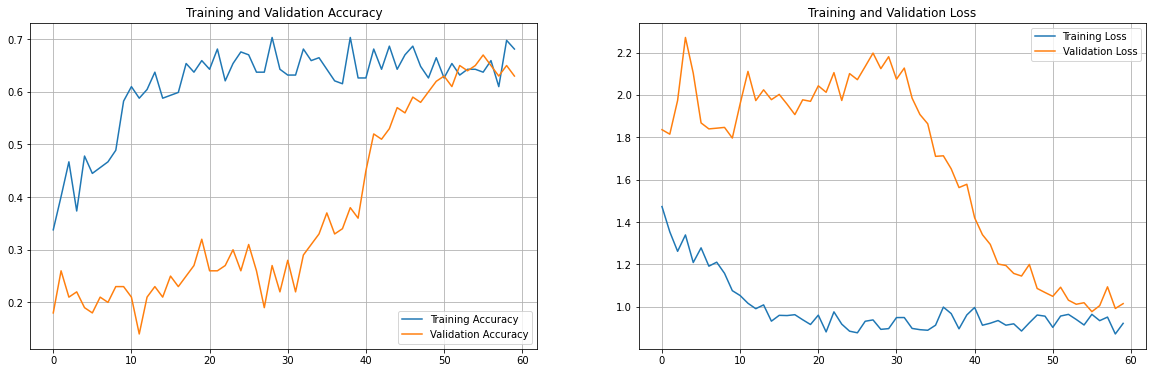

In [24]:
# Plot the results
plot_acc(history)

### Inference - 3
- Both Train and Validation accuracy reach aruond 65%. 
- We see that this model has surely under-perfomed compared to the model 2.1 
- This does not rule out that the performance can be inproved with different set of parameters and more experiments
- However, this being an option part, we will not pursue it any further
### The best model is still 2.1

### Model 4: GRU -  resolution to 160x160 and epochs=60, filter=(2,2,2) 
### *This is optional and not needed since we have already built our model using Conv3D. But we still want to try LSTM and GRU models for our own learning*
#### Parameters

- image_width = 160
- image_height = 160 
- batch_size = 50 
- num_epochs = 60

## GRU

In [25]:
def gru_1_compile(act_frames, image_height, image_width, optimizer):
    print('Image= ', image_width, 'X', image_height)

    model_g = Sequential()

    model_g.add(TimeDistributed(Conv2D(16, (2,2) , padding='same', activation='relu'),
                                  input_shape=(act_frames,image_height,image_width,3)))
    model_g.add(TimeDistributed(BatchNormalization()))
    model_g.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_g.add(TimeDistributed(Conv2D(32, (2,2) , padding='same', activation='relu')))
    model_g.add(TimeDistributed(BatchNormalization()))
    model_g.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_g.add(TimeDistributed(Conv2D(64, (2,2) , padding='same', activation='relu')))
    model_g.add(TimeDistributed(BatchNormalization()))
    model_g.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_g.add(TimeDistributed(Conv2D(128, (2,2) , padding='same', activation='relu')))
    model_g.add(TimeDistributed(BatchNormalization()))
    model_g.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_g.add(TimeDistributed(Conv2D(256, (2,2) , padding='same', activation='relu')))
    model_g.add(TimeDistributed(BatchNormalization()))
    model_g.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_g.add(TimeDistributed(Conv2D(512, (2,2) , padding='same', activation='relu')))
    model_g.add(TimeDistributed(BatchNormalization()))
    model_g.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_g.add(TimeDistributed(Flatten()))
    model_g.add(GRU(64,return_sequences = False))
    model_g.add(Dropout(0.2))
        
    model_g.add(Dense(32,activation='relu'))
    model_g.add(Dropout(0.2))
        
    model_g.add(Dense(5, activation='softmax'))
    
    
    #Now that you have written the model, the next step is to compile the model. 
    #When you print the summary of the model, you'll see the total number of parameters you have to train.

    
    optimiser = optimizer
    model_g.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model_g.summary())
    
    return model_g

In [28]:
image_width = 160
image_height = 160
batch_size = 50
num_epochs = 60


model = gru_1_compile(act_frames, image_height, image_width, 'adam')

Image=  160 X 160
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_35 (TimeDis (None, 20, 160, 160, 16)  208       
_________________________________________________________________
time_distributed_36 (TimeDis (None, 20, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_37 (TimeDis (None, 20, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 20, 80, 80, 32)    2080      
_________________________________________________________________
time_distributed_39 (TimeDis (None, 20, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_40 (TimeDis (None, 20, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_41 (TimeDis (None, 

In [29]:
# Train the model
history = train_model(train_path, train_doc, batch_size, model)

Source path =  Project_data/train ; batch size = 50 ; Image width = 160 ; Image height = 160
Epoch 1/60
14/14 [==============================] - 52s 4s/step - loss: 1.6171 - categorical_accuracy: 0.2763 - val_loss: 2.1112 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 2.11119, saving model to model_init_2022-07-1216_45_46.961717/model-00001-1.47020-0.34691-2.11119-0.27000.h5
Epoch 2/60
14/14 [==============================] - 22s 2s/step - loss: 1.3803 - categorical_accuracy: 0.4118 - val_loss: 2.7458 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 2.11119
Epoch 3/60
14/14 [==============================] - 21s 2s/step - loss: 1.2617 - categorical_accuracy: 0.4844 - val_loss: 2.7528 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 2.11119
Epoch 4/60
14/14 [==============================] - 22s 2s/step - loss: 1.1473 - categorical_accuracy: 0.5771 - val_loss: 2.6388 - val_categorical_accuracy: 0

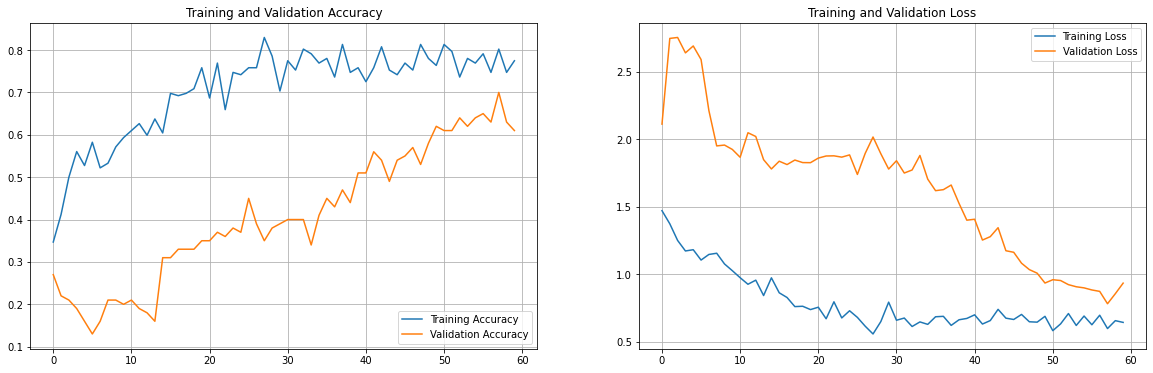

In [30]:
# Plot the results
plot_acc(history)

### Inference - 4
- As expected, this GRU model is not doing a better job than the corresponing LSTM (model 3) model.
- Train accuracy = 75% and Validation accuracy = 65%. 
- We see that this model has surely under-perfomed compared to the model 2.1. 
- This does not rule out that the performance can be inproved with different set of parameters and more experiments.
- However, this being an option part, we will not pursue it any further.
### The best model is still 2.1

## After all the experiments, we finalize model 2.1 (Conv3D) as our preferred model
### Model Parameters 

- image_width = 160
- image_height = 160
- batch_size = 50
- num_epochs = 60
#### Train Accuracy = 85%
#### Validation Accuracy = 80%
#### Total params = 911,861
#### h5 file for the best weights= model_init_2022-07-1212_20_25.541892/model-00048-0.46408-0.82967-0.65267-0.73000.h5

## Load the best model and test

In [2]:
# Loading the model 2.1 h5 file

from tensorflow.keras.models import load_model
model = load_model('model_init_2022-07-1212_20_25.541892/model-00048-0.46408-0.82967-0.65267-0.73000.h5')

In [26]:
# Testing the model using a random image from the validation data set

image_width = 160
image_height = 160
batch_size = 1
act_frames = 20

# Get one random image from validation data set
one_img = generator(val_path, val_doc, batch_size)
one_img_data, one_img_label = next(one_img)

# Actual Class
print('Actual Class of the Image:    ', list(one_img_label[0]).index(1))

# Predicted Class
print('Predicted Class of the Image: ', np.argmax(model.predict(one_img_data), axis = 1)[0])


Source path =  Project_data/val ; batch size = 1 ; Image width = 160 ; Image height = 160
Actual Class of the Image:     3
Predicted Class of the Image:  3


### Inference:
The model has correctly predicted the class for image randomly choses